In [38]:
# Importing Data
import pickle
from data_creation import get_pickle, show_img

# Data Manipulation and Model Loading
import pandas as pd
import numpy as np
import keras
from keras import models
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.models import load_model
import os
import cv2

# Visualization
import matplotlib.pyplot as plt
import pydot_ng as pydot
keras.utils.vis_utils.pydot = pydot

## Importing Data

In [39]:
X_grayscale, y_grayscale = get_pickle('X_grayscale.pickle', 'y_grayscale.pickle')
X_color, y_color = get_pickle('X_color.pickle', 'y_color.pickle')

In [40]:
pickle_predictions = open('model_predictions.pickle', 'rb')
predictions = pickle.load(pickle_predictions)
pickle_predictions.close()

In [41]:
categories = ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango',
              'Muskmelon', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya',
              'Plum', 'Pomegranate', 'Tomato']

#### Converting the integer inputs to their proper labels

In [42]:
predictions['Actual'] = predictions.Actual.apply(lambda x: categories[x])
predictions['Predicted'] = predictions.Predicted.apply(lambda x: categories[x])

## Class Distribution

In [43]:
labels, counts = np.unique(y_grayscale, return_counts=True)
counts = counts/counts.sum()
fruit_counts = dict(sorted(zip(categories, counts), key=lambda x: x[1], reverse=True))

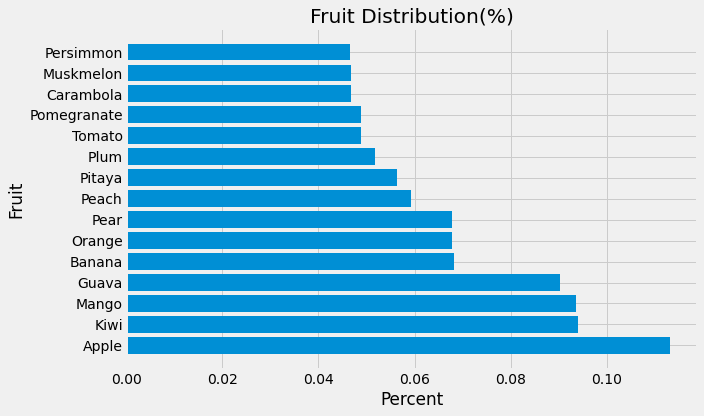

In [44]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
plt.barh(list(fruit_counts.keys()), list(fruit_counts.values()))
plt.xlabel('Percent')
plt.ylabel('Fruit')
plt.title('Fruit Distribution(%)')
plt.tight_layout()
plt.savefig('Images/fruit_dist.png', transparent=True)

## Exploring Model Predictions

In [45]:
true_label_spread = dict(predictions.Actual.value_counts(normalize=True))
predicted_label_spread = dict(predictions.Predicted.value_counts(normalize=True))

Combining the values into a dict so that the indices match

In [46]:
df_dict = {}
for k in true_label_spread:
    df_dict[k] = (true_label_spread[k], predicted_label_spread[k])

Getting the true and predicted label percentages of each

In [47]:
true_labels = []
predicted_labels = []
for key in df_dict.keys():
    true_labels.append(df_dict[key][0])
    predicted_labels.append(df_dict[key][1])

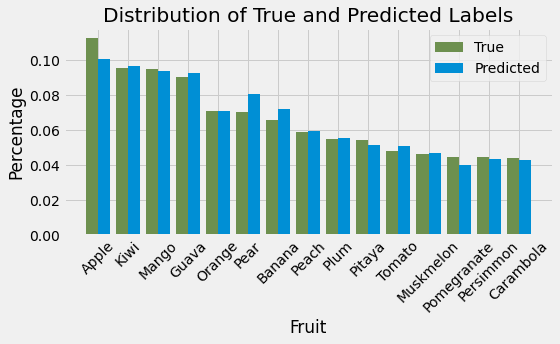

In [48]:
n = 15
ind = np.arange(n) 
width = 0.4
plt.figure(figsize=(8,5))
plt.bar(ind, true_labels, width, label='True', color='C3')
plt.bar(ind + width, predicted_labels, width, label='Predicted', color='C0')
plt.xticks(ind + width / 2, list(df_dict.keys()), rotation=45)
plt.ylabel('Percentage')
plt.xlabel('Fruit')
plt.title('Distribution of True and Predicted Labels')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('Images/true_pred_spread.png', transparent=True)

### Closer look at Incorrect Predictions

Getting the incorrect predictions for each class. Then, for each class's set of predictions I change the amounts to percents.

In [49]:
wrong_preds = {}
for category in categories:
    temp_df = predictions[(predictions['Actual']==category)&(predictions['Predicted']!=category)]
    percents = dict(temp_df.Predicted.value_counts(normalize=True))
    wrong_preds[category]=percents
wrong_preds_df = pd.DataFrame(wrong_preds)

NA values will be filledin as 0.0

In [50]:
wrong_preds_df.fillna(0.0, inplace=True)

In [51]:
wrong_preds_df

,Apple,Banana,Carambola,Guava,Kiwi,Mango,Muskmelon,Orange,Peach,Pear,Persimmon,Pitaya,Plum,Pomegranate,Tomato
Pear,0.262295,0.209302,0.000000,0.333333,0.166667,0.088235,0.613636,0.000000,0.28,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Muskmelon,0.224044,0.023256,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.00,0.176471,0.000000,0.000000,0.0,0.000000,0.0
Tomato,0.180328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.086957,0.12,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Peach,0.131148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.032258,0.0,0.000000,0.1
Kiwi,0.071038,0.000000,0.000000,0.041667,0.000000,0.029412,0.000000,0.000000,0.00,0.058824,0.166667,0.000000,0.0,0.039216,0.0
Pitaya,0.049180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Guava,0.043716,0.139535,0.692308,0.000000,0.666667,0.000000,0.136364,0.000000,0.00,0.411765,0.000000,0.000000,0.0,0.019608,0.0
Mango,0.021858,0.511628,0.076923,0.083333,0.000000,0.000000,0.000000,0.652174,0.00,0.000000,0.000000,0.000000,0.0,0.235294,0.0
Pomegranate,0.005464,0.023256,0.000000,0.000000,0.000000,0.073529,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Carambola,0.005464,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.019608,0.0


The columns are the true labels and the indices are the predicted label. Each value is the percent that that predicted label is of incorrect labels.
For example, we will look at the incorrectly predicted labels for Apple's below. We can see that of the incorrectly the all the incorrect labels the model made for apples, 26.22% were marked as pears.

In [52]:
wrong_preds_df['Apple']

Pear           0.262295
Muskmelon      0.224044
Tomato         0.180328
Peach          0.131148
Kiwi           0.071038
Pitaya         0.049180
Guava          0.043716
Mango          0.021858
Pomegranate    0.005464
Carambola      0.005464
Banana         0.005464
Apple          0.000000
Plum           0.000000
Orange         0.000000
Persimmon      0.000000
Name: Apple, dtype: float64

## Visualizing CNN Architecture

Load Model

In [53]:
model_10 = load_model('model.h5')

I need this to make the model visualization work

In [54]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Plotting my best model

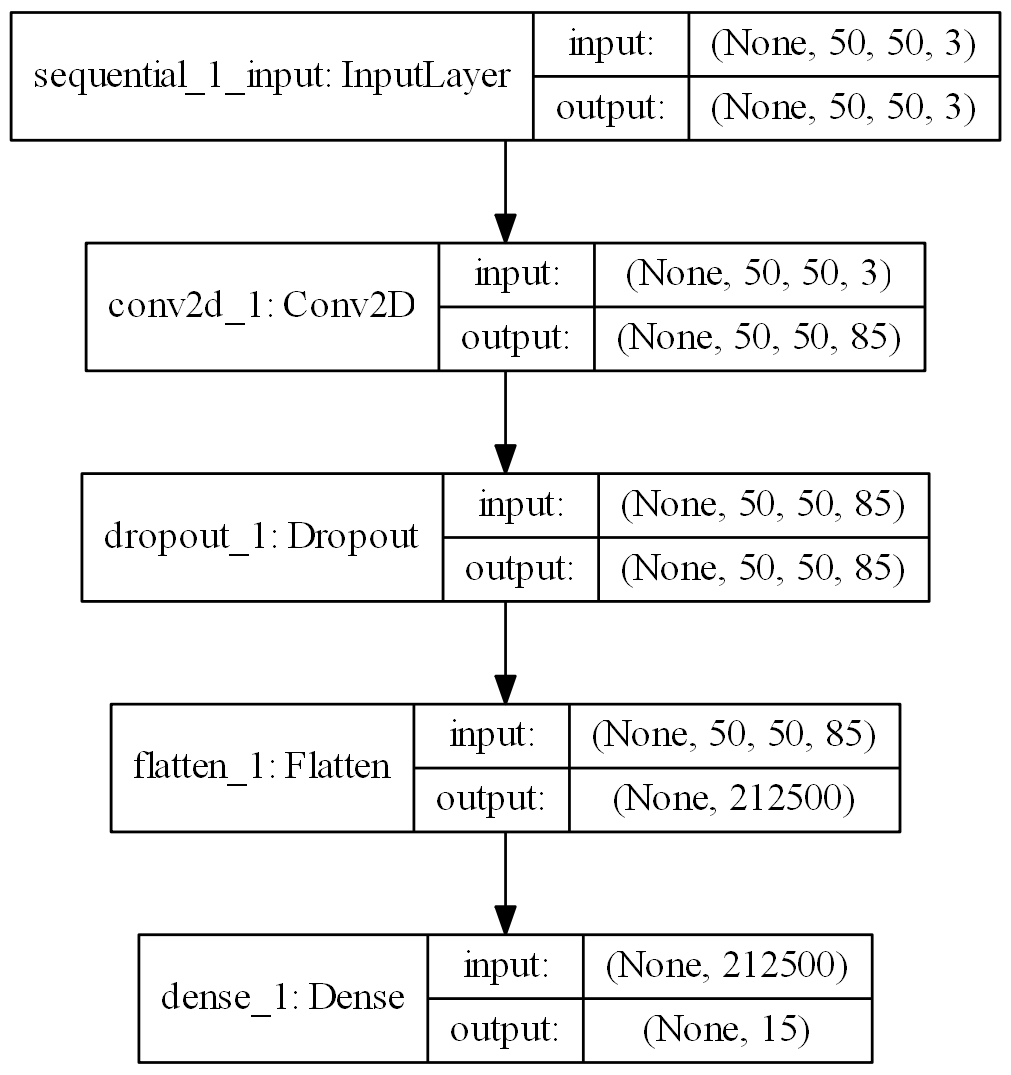

In [55]:
plot_model(model_10, to_file='Images/model.png',dpi=200, show_shapes=True)

## Further Breakdown of CNN

In [56]:
path = 'C://Users/Cristian/Documents/flatiron/Capstone/Fruit/Pitaya/Pitaya001.png'

I will grab the first image of a Pitaya to show what the model does on the first and last layer.

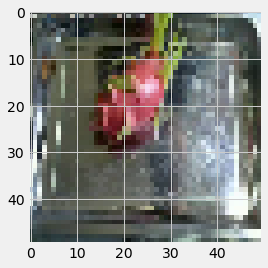

In [57]:
example = show_img(path,50)

In [58]:
layer_outputs = [layer.output for layer in model_10.layers[:4]]
activation_model = models.Model(inputs=model_10.input, outputs=layer_outputs)

In [59]:
activations = activation_model.predict(example.reshape(1,50,50,3))

In [60]:
first_layer = activations[0]

I want to visualize what my neurons are picking up on. To do this, I will select 10 neurons at random and plot them all side by side.
I will use a color map to show what it is picking up on and what it does not.

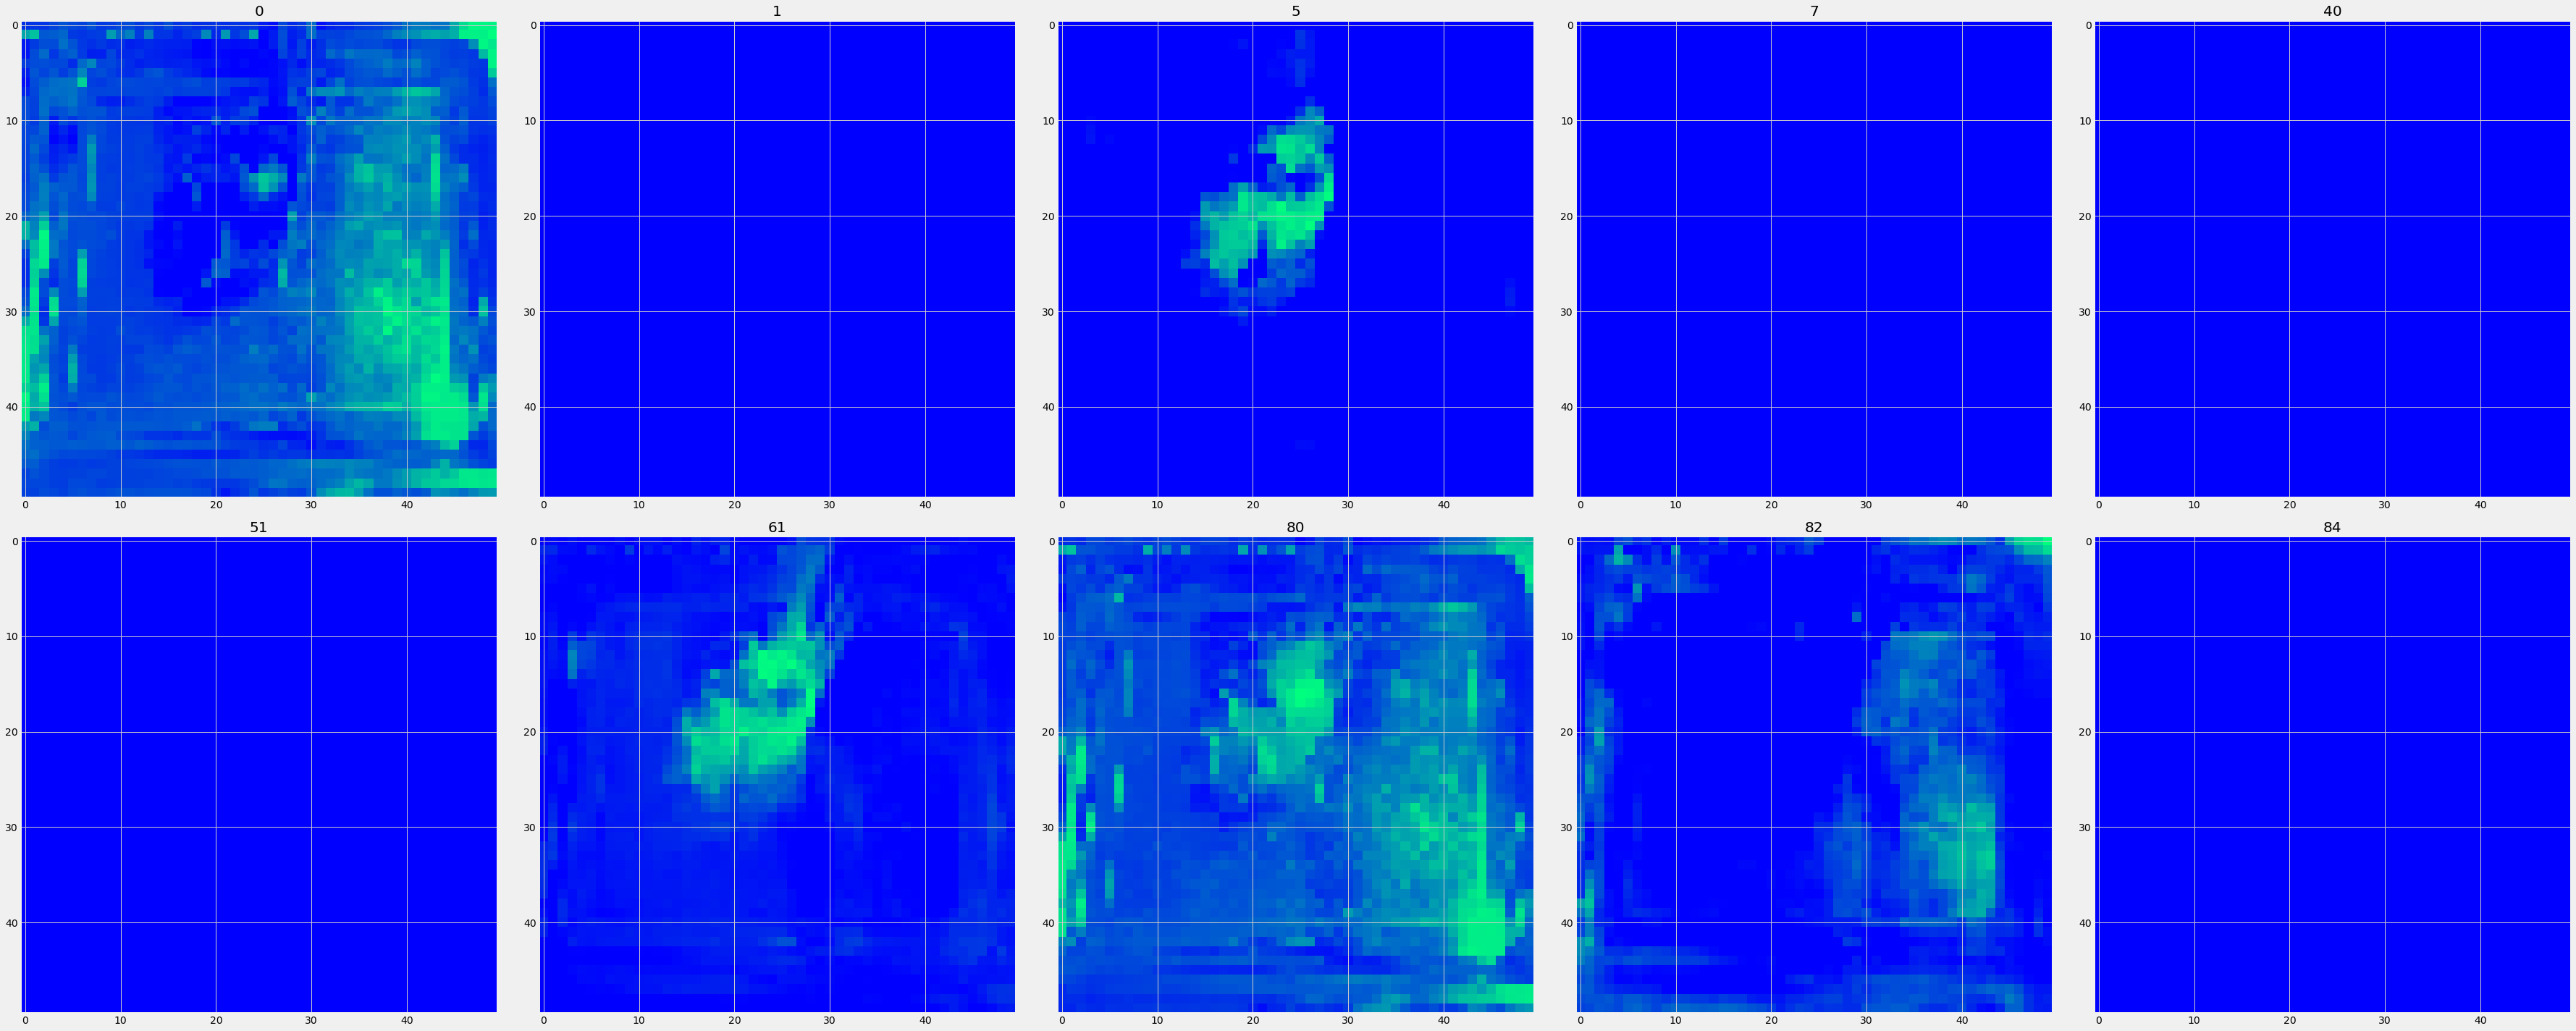

In [61]:
fig=plt.figure(figsize=(50,20))
columns=5
rows=2
my_10 = sorted(np.random.choice(85,10,replace=False))

for i in range(1, columns*rows+1):
    fig.add_subplot(rows,columns,i)
    for pic in my_10:
        plt.imshow(first_layer[0, :, :, my_10[i-1]],cmap='winter')
        plt.title(str(my_10[i-1]))
plt.tight_layout()
plt.savefig('Images/example_breakdown.png', transparent=True)
plt.show()

As we can see, some of the neurons are picking up on trends in the shape of our pitaya. Others seem to pick up nothing at all. There are also neurons
that are picking up on the background of our photo. It seems to be picking up on the shine of the metal tray all fruits are being placed on. 

Below I will look visualize how the last layer is outputting the predicted value.

(1, 15)


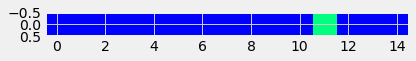

In [62]:
last_layer = activations[3]
print(last_layer.shape)
plt.imshow(last_layer, cmap='winter')
plt.tight_layout()
plt.savefig('Images/output_layer.png', transparent=True)

As seen, the plot is from 0 to 14, an integer for each of the classes of fruit. My model predicted an output of 11, which corresponds to the index of 'categories'.

In [63]:
categories[11]

'Pitaya'